### Задача

Правда ли бикас дает преимущество? Или лучше разгонять без всяких там бикасов

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq

#### Простая цилиндрическая пушка

q_max = 0.12166999999999997


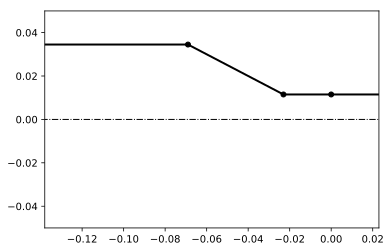

In [10]:
d = 23e-3
C_q_max = 10
q_max = C_q_max * (d*10)**3
print(f'q_max = {q_max}')


tube_dict = {
    'tube_points': [[-d*100,3*d],[-d*3,3*d],[-d,d],[0, d], [100*d, d]]
}
tube = Tube.get_standart(tube_dict)
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.05,0.05)
fig.set_xlim(-6*d,d)
plt.show()

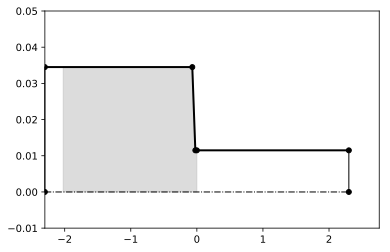

GasLayer(n_cells=300); 
        {'p_max':100000000.0, 'tau_min': 3.3977485681494286e-06, 
        'u_max': 0.0, 'cs_max': 1984.1225980567192, 'dx_min': 0.006741549716580142, 
        'x_1': -2.02246491497408, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [11]:
gas_layer_dict = {
    'type': 'gas',
    'name': 'He',
    'gamma': 1.66,
    'kappa': 0.005925,
    'R': 2078,
    'T_0': 300, # K
    'W_0': 0.0003,  # м^3 объем газа
    'p_0': 100e6, # начальное давление газа
    'u_0': 0,     #начальная скорость
    'x_2': 0
}

calc_settings = {
    'cell_dx': 0.0025,
    'n_cells': 300,
    'n_cells_min': 13,
    'n_cells_max': 300,
    'GasFluxCalculator_kwargs': {'flux_type':2, 'x_order':1},
    'GridStrecher_kwargs': {}
} 

ro_0 = gas_layer_dict['p_0']/(gas_layer_dict['R']*gas_layer_dict['T_0'] + gas_layer_dict['p_0']*gas_layer_dict['kappa'])
omega = q_max * 5
gas_layer_dict['W_0'] = omega / ro_0
x1 = tube.get_x1(gas_layer_dict['x_2'], gas_layer_dict['W_0'])

gl = GasLayer.get_standart(tube, x1, gas_layer_dict, calc_settings)   

fig, ax = plt.subplots()
tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.01,0.05)
ax.set_xlim(-100*d,120*d)
plt.show()

gl

In [12]:
lrs = [gl]
b = BorderSimple(gl, None, q_max, 0)
vl = 0
for i in tqdm_notebook(range(20000)):
    if lrs[-1].xs_borders[-1] > tube.get_xs()[-1]:
        break
    tau = lrs[-1].get_tau_min()*0.3
    b.update_xs()
    b.update_Vs(tau)
    gl = gl.step_up(tau, False)
    lrs.append(gl)
    b.lr_left = gl
    
    

In [14]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=100, value=0))
def plotMe(ind):
    
    lr = lrs[ind]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    tube.plot(fig, ax2)
    ax2.set_ylim(-0.005, 0.09)
    lr.plot(fig, ax2)
    
    param_name = 'us'
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax0.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')

    ax0.grid(True)
    ax0.set_ylabel(param_name)
#     ax0.set_ylim(900,1000)
    ax0.set_title(f't={lr.time*1000} ms; i={ind}')
    ax0.legend()
    
    param_name = 'ps'
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax1.plot(xs, ys/1e5, color=color, lw=lw, label=f'{param_name} газ')
    
    
    ax1.grid(True)
    ax1.set_ylabel(f'$p$, атм.')
#     ax1.set_ylim(-500,700)
#     ax1.set_title(f't={lr.time*1000} ms; i={ind}')
    ax1.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=3545, step=100), Output()), _dom_classes=('wid…